<a href="https://colab.research.google.com/github/Beh-noush/General-Python/blob/main/Linear_vs_Non_Linear_Classification_(From_IFT6269).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

We will compare the performance of several algorithm on some synthetic classification tasks. The assignment consists of two parts: 1) a derivation of the estimators for the Fisher LDA with general covariance matrix derivation and 2) the implementation of several classification algorithms.



In [ ]:
!wget http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk2data.zip
!unzip hwk2data.zip

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

--2020-10-13 14:50:29--  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A20/notes/hwk2data.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70575 (69K) [application/zip]
Saving to: ‘hwk2data.zip’

hwk2data.zip        100%[===================>]  68.92K   187KB/s    in 0.4s    

2020-10-13 14:50:30 (187 KB/s) - ‘hwk2data.zip’ saved [70575/70575]

Archive:  hwk2data.zip
  inflating: hwk2data/classificationA.test  
  inflating: hwk2data/classificationA.train  
  inflating: hwk2data/classificationB.test  
  inflating: hwk2data/classificationB.train  
  inflating: hwk2data/classificationC.test  
  inflating: hwk2data/classificationC.train  


We take 3 different datasets (**A**, **B**, **C**) with a training and test set for each, i.e., 6 sets in total. Each row represents a sample of data $(x_i, y_i)$. There are three columns: the first two give the coordinates for $x_i \in \mathbb{R}^2$; the third column gives the class label $y_i \in \{0, 1\}$. The datasets are all generated from some kind of mixture of Gaussians generative model. The train and test sets are generated from the same distribution for each types of dataset. 

The actual generating process is as follows.
*  **Dataset A**: the class-conditionals for this dataset are Gaussians with different means, but with a shared covariance matrix $\Sigma$.
*  **Dataset B**: similar generating process but the covariance matrices are different for the two classes.
*  **Dataset C**: here one class is a mixture of two Gaussians, while the other class is a single Gaussian (with no sharing).

We test the different models learnt from the corresponding training data on the test data. We compute for each model the accuracy (i.e.  the fraction of the data correctly classified) on the training set and compute it as well for the test set and compare the performances of the different methods on the three datasets.


In [ ]:
data = {}

for d_ix in ["A", "B", "C"]:
    for t_flag in ["train", "test"]:
        data[t_flag + "_" + d_ix] = np.loadtxt("/content/hwk2data/classification"+d_ix+"."+t_flag)

### Models

**Fisher LDA**
>  We first consider the Fisher LDA model as seen in class: given the class variable, the data are assumed to be Gaussians with different means for different classes but with the same covariance matrix: $Y \sim \text{Bernoulli}(\pi)$, $X | \{Y = j\} \sim \mathcal{N}(\mu_j, \Sigma)$.

**Logistic Regression**
>  Implement logistic regression for an affine function $f(x) = w^Tx+b$ (do not forget the constant term – you can use the bias feature trick) using the IRLS algorithm (Newton’s method) which was described in class. Hint: never compute the matrix inverse by itself – this is not numerically stable when the Hessian might become ill-conditioned.

**Linear regression**

> As mentioned in class, we can forget that the class $y$ can only take the two values $0$ or $1$ and think of it as a real-valued variable on which we can do standard linear regression (least-squares). Here, the Gaussian noise model on $y$ does not make any sense from a generative point of view; but we can still do least-squares to estimate the parameters of a linear decision boundary (you’ll be surprised by its performance despite coming from a “bad”
generative model!). Implement linear regression (for an affine function $f(x) = w^Tx + b$) by solving the normal equations on each dataset (with no regularization).


**QDA**
>  We finally relax the assumption that the covariance matrices for the two classes are the same. So, given the class label, the data are now assumed to be Gaussian with means and covariance matrices which are a priori different:
$Y \sim \text{Bernoulli}(\pi)$, $X | \{Y = j\} \sim \mathcal{N}(\mu_j, \Sigma_j)$.

#Fisher LDA



We first derive the form of the maximum likelihood estimator for the Fisher LDA model described above. We get inspiration from Section 7.2 in Mike’s book (which covers the case where $\Sigma$ is diagonal).

From the i.i.d. property of the data, the joint probability over $n$ data points is factorized as the multiplication of $n$ probability terms, each one corresponding to an individual datapoint.  $$l(\theta|D) = \sum_{n=1}^N\log[p(x_n,y_n|\theta)] = l(\theta|D) = \sum_{n=1}^N\ln[p( y_n|\theta)p(x_n,y_n|\theta)] = \sum_{n=1}^N\ln[\pi^{y_n}(1-\pi)^{1-y_n}\mathcal{N}(x_n;\mu_{y_n},\Sigma)]= \sum[y_n\ln\pi+(1-y_n)\ln(1-\pi)]+\sum_{i=1}^N\ln\mathcal{N}(x_n;\mu_n,\Sigma)$$
We notice that the first term depends only on $\pi$ and all dependence on the mean and covariance are included in the second term. Therefore, to do MLE estimation, we treat these two terms independently. We write the second one as
$$
l(\mu_1,\mu_0,\Sigma) = \sum_{n=1}^n \mathbb{I}_{y_n=1}\ln \mathcal{N}(x_n,\mu_1,\Sigma) +\mathbb{I}_{y_n=0}\ln \mathcal{N}(x_n,\mu_0,\Sigma) $$.
We have seen the expression for the logarithm of the normal distribution in the class. Writing only the relevant termss (the ones including the parameters to estimate)
$$l(\mu_1,\mu_0,\Sigma) = \sum_{n=1}^Ny_n[-\frac12\ln|\Sigma|-\frac12(x_n-\mu_1)^T\Sigma^{-1}(x_n-\mu_1)]+(1-y_n)[-\frac12\ln|\Sigma|-\frac12(x_n-\mu_0)^T\Sigma^{-1}(x_n-\mu_0)]$$

Now, to estimate the means, we take derivative of this expression w.r.t. $\mu_1$ and $\mu_0$ to find the stationary point.
$$\frac{\partial}{\partial_{\mu_1}}l(\mu_1,\mu_0,\Sigma) =  \frac{\partial}{\partial_{\mu_1}}\sum_{n=1}^N-\frac12(x_n-\mu_1)^T\Sigma^{-1}(x_n-\mu_1)] = \sum_{n=1}^N -\frac{y_n}22\Sigma^{-1}(x_n - \mu_1) = \Sigma^{-1}\sum_{n=1}^N - y_n (x_n - \mu_1) = 0$$.
With PSD (Positive Semi-Definite) property of covariance matrix, we can multiply both sides by $\Sigma$ and therefore, we end up with $\sum - y_n (x_n - \mu_1) = 0$ which results in 
$$\mu_1 = \frac{\Sigma_{n=1}^Ny_n x_n}{\Sigma_{n=1}^Ny_n}$$
 
 Along the same lines of this proof, we can estimate $\mu_0$ and the result is 
$$\mu_0 = \frac{\Sigma_{n=1}^N(1-y_n) x_n}{\Sigma_{n=1}^N(1-y_n)}
$$

Next, we estimate $\Sigma$ or as we saw in the PGM class, equivalently and more easily $\Sigma^{-1}$. 
$$\frac{\partial}{\partial_{\Sigma^{-1}}}l(\mu_1,\mu_0,\Sigma) =  \frac{\partial}{\partial_{\Sigma^{-1}}}\sum_{n=1}^N -\frac12\ln|\Sigma|-\frac{y_n }2(x_n-\mu_1)^T\Sigma^{-1}(x_n-\mu_1)-\frac{(1-y_n)}2(x_n-\mu_0)^T\Sigma^{-1}(x_n-\mu_0) $$

We can replace the first term $\ln|\Sigma|$ with $-\ln|\Sigma^{-1}|$, so that we have all terms written in terms as $\Sigma^{-1}$. 
Also we rewrite the following term
$$Tr((x-\mu_i)^T\Sigma^{-1}(x-\mu_i)) = <\Sigma^{-1},(x-\mu)(x-\mu)^T>$$

Then we use the  following derivative identities:
 
1)$\frac{\partial}{\partial_{A}}\ln|A| = A^{-1}$

2)$\frac{\partial}{\partial_{A}}Tr(AB) = B^T$

The first one, results in 
$$\frac{\partial}{\partial_{\Sigma^{-1}}}\sum_{n=1}^N -\frac12\ln|\Sigma| = \frac{\partial}{\partial_{\Sigma^{-1}}}\sum_{n=1}^N \frac12\ln|\Sigma^{-1}| = N\frac{\partial}{\partial_{\Sigma^{-1}}} \frac12\ln|\Sigma^{-1}| =  \frac{N}2\Sigma $$

The second one gives
$$\frac{\partial}{\partial_{\Sigma^{-1}}}\sum_{n=1}^N  -\frac{y_n }2(x_n-\mu_1)^T\Sigma^{-1}(x_n-\mu_1)-\frac{(1-y_n)}2(x_n-\mu_0)^T\Sigma^{-1}(x_n-\mu_0) =  \frac{\partial}{\partial_{\Sigma^{-1}}}\sum_{n=1}^N  -\frac{y_n }2<(\Sigma^{-1},(x_n-\mu_1)(x_n-\mu_1)^T>-\frac{(1-y_n)}2<\Sigma^{-1},(x_n-\mu_0)(x_n-\mu_0)^T> = \sum_{n=1}^N  -\frac{y_n }2 (x_n-\mu_1)(x_n-\mu_1)^T-\frac{(1-y_n)}2(x_n-\mu_0)(x_n-\mu_0)^T$$
where we used the fact that $(x_n-\mu_0)(x_n-\mu_0)^T$ is symmetric.
Putting these pieces together,
$$\frac{\partial}{\partial_{\Sigma^{-1}}}l(\mu_1,\mu_0,\Sigma) =  \frac{N}2\Sigma \sum_{n=1}^N  -\frac{y_n }2 (x_n-\mu_1)(x_n-\mu_1)^T-\frac{(1-y_n)}2(x_n-\mu_0)(x_n-\mu_0)^T =0$$
results in 
$$\Sigma = \frac1N\sum_{n=1}^N(y_n(x_n-\mu_1)(x_n-\mu_1)^T+(1-y_n)(x_n-\mu_0)(x_n-\mu_0)^T)$$.

The logarithmic term is concave in $\Sigma^{-1}$ as we saw in the class. Besides that, the trace term is linear in $\Sigma^{-1}$ and since it has also a negative sign behind it, it keeps the concave property of the likelihood functional intact. Therefore, the stationary point is a global maximum.

Also, the stationary point for $\mu_1$ and $\mu_0$ is a global max, because the likelihood function is quadratic in them and with the minus sign behind, it is a concave function.

Finally, to estimate $\pi$ it is only the first term above contributing to it as 
$$l(\pi) = \sum[y_n\ln\pi+(1-y_n)\ln(1-\pi)]$$
therefore
$$\frac{\partial(l(\pi))}{\partial\pi} = \frac{\partial(l(\pi))}{\partial\pi}\sum[y_n\ln\pi+(1-y_n)\ln(1-\pi)] = \sum_{n=1}^N\frac{y_n}{\pi}-\frac{(1-y_n)}{(1-\pi)} = 0$$
which results in 
$$\pi = \frac{\sum_{n=1}^Ny_n}{N}$$ as expected intuitively.

**Question B:** What is the form of the conditional distribution $p(y = 1|x)$? Compare with the form of logistic regression

**Answer:** Using Bayes' rule we have 
$$p(y = 1|x) = \frac{p(x |y=1)p(x)p(y=1)}{p(x)}$$
rewriting the denominator as a marginal probability
$$p(y = 1|x) = \frac{p(x |y=1) p(y=1)}{p(x|y=1)p(y=1)+p(x|y=0)p(y=0)} $$
replacing normal distributions, we get
$$P(y=1|x) = \frac{\pi \exp{(x_n-\mu_1)^T\Sigma^{-1}(x_n-\mu_1)}}{\pi \exp{(x_n-\mu_1)^T\Sigma^{-1}(x_n-\mu_1)}+(1-\pi) \exp{(x_n-\mu_0)^T\Sigma^{-1}(x_n-\mu_0)}}$$
Dividing both numerator and the denominator by the expression in the numerator, we get
$$P(y=1|x) = \frac{1}{1+\frac{(1-\pi)}{\pi} e^{(x_n-\mu_0)^T\Sigma^{-1}(x_n-\mu_0)- {(x_n-\mu_1)^T\Sigma^{-1}(x_n-\mu_1)}}}$$

Now, to compare to the logistic regression, we notice that the quadratic terms in $x$ cancel eachother. So, we simplify this expression to
$$P(y=1|x) = \frac{1}{1+ e^{\ln\frac{(1-\pi)}{\pi}- (\mu_1-\mu_0)^T\Sigma^{-1}(x)+\frac12  (\mu_1-\mu_0)^T\Sigma^{-1}(\mu_0+\mu_1)}}$$
which has the exact ly same form as logistic function.


## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions! 

In [ ]:
def LDA(X, y):
    """
    Estimates the parameters of an LDA model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            LDA_classifier: function taking two scalar inputs implementing the
                            estimated p(y=1|x)
    """
    # TODO: parameter estimation goes here
    mu1 = np.sum(np.reshape(y,(len(y),1))*X,axis=0)/np.sum(y)
    mu0 = np.sum(np.reshape((1-y),(len(y),1))*X,axis=0)/np.sum(1-y)
    
    M1=0
    M2=0
    for i in range(len(X)):
        M1+= y[i]*((np.reshape(X[i,:],(1,2))-mu1).T*(np.reshape(X[i,:],(1,2))-mu1))
        M2+= (1-y[i])*((np.reshape(X[i,:],(1,2))-mu0).T*(np.reshape(X[i,:],(1,2))-mu0))
    Sigma = (M1+M2)/len(y)
    
    pi  = np.sum(y)/(len(y)) 
    #Sigma = (1/len(y))*(np.sum(y*((x-mu1)*np.transpose(x-mu1))))
    def LDA_classifier(x0, x1):
         # TODO: use the variables estimated above to define p(y=1|(x0, x1))
        np.reshape(mu1,(2,1))
        np.reshape(mu0,(2,1))
        beta = np.dot(np. linalg. inv(Sigma),(mu1-mu0))
        muminus= mu1-mu0
        muplus = mu1+mu0
        gamma = -1/2*np.dot(muminus.T, np.dot(np. linalg. inv(Sigma),muplus))
        gamma+=np.log(pi/(1-pi))
        denom = 1+np.exp(-np.dot(beta.T,np.array([x0,x1]))-gamma)
        return(1/denom)
    return LDA_classifier



def LogReg(X, y):
    """
    Estimates the parameters of a Logistic Regression model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            LogReg_classifier: function taking two scalar inputs implementing the
                               estimated p(y=1|x)
    """
    # TODO: parameter estimation goes here
    bias = np.ones((len(y),1))
    X = np.concatenate((X,bias),1)
    w = np.random.randn(3,1) #initialization of parameters
    prop = 1
    iter = 0
    while prop>1e-3:
        iter+= 1
        span = np.dot(X,w) # a nx1 vector, like y
        sigmoid = (np.exp(-span)+1)**(-1)
        mm = sigmoid*(1-sigmoid)+1e-8
        Dmatrix = np.diag(mm.T[0])
        z= span+ np.dot(np.linalg.inv(Dmatrix),np.reshape(y,(len(y),1))-sigmoid)
        #Now we write the terms in least squares problem
        t1 = np.dot(X.T, np.dot(Dmatrix, X))
        t2 = np.dot(X.T, np.dot(Dmatrix, z))
        w_new = np.linalg.lstsq(t1, t2, rcond=None)[0]
        w_dif = w-w_new
        norm_dif = w_dif[0]**2 + w_dif[1]**2 + w_dif[2]**2
        norm_w = w[0]**2 + w[1]**2 + w[2]**2
        prop = (norm_dif/norm_w)
        #prop = norm_dif
        w = w_new

        #gradw = np.reshape( np.sum(X*(np.reshape(y,(len(y),1))-sigmoid),0) , (3,1))  
        #w+= -1e-4*gradw 
        #absol = w[0]**2+w[1]**2+w[2]**2
        #if absol<1e-6:
         # break 
    print(iter)
    def LogReg_classifier(x0, x1):
         # TODO: use the variables estimated above to define p(y=1|(x0, x1))
        span = x0*w[0]+x1*w[1]+w[2]
        sigmoid = (np.exp(-span)+1)**(-1)

        return sigmoid
    
    return LogReg_classifier



def LinReg(X, y):
    """
    Estimates the parameters of a Linear Regression model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            LinReg_classifier: function taking two scalar inputs implementing the
                               estimated f(x)
    """
    # TODO: parameter estimation goes here
    bias=np.ones((len(y),1))
    X = np.concatenate((X,bias),1)
    w=np.dot(np.linalg.inv(np.dot((X.T),X)), np.dot((X.T),y))

    def LinReg_classifier(x0, x1):

         # TODO: use the variables estimated above to implement f(x0, x1)
        return w[0]*x0+w[1]*x1+w[2]
    
    return LinReg_classifier


def QDA(X, y):
    """
    Estimates the parameters of a QDA model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            QDA_classifier: function taking two scalar inputs implementing the
                            estimated p(y=1|x)
    """
    # TODO: parameter estimation goes here
    mu1 = np.sum(np.reshape(y,(len(y),1))*X,axis=0)/np.sum(y)
    mu0 = np.sum(np.reshape((1-y),(len(y),1))*X,axis=0)/np.sum(1-y)
    
    M1=0
    M2=0
    for i in range(len(X)):
        M1+= y[i]*((np.reshape(X[i,:],(1,2))-mu1).T*(np.reshape(X[i,:],(1,2))-mu1))
        M2+= (1-y[i])*((np.reshape(X[i,:],(1,2))-mu0).T*(np.reshape(X[i,:],(1,2))-mu0))
    Sigma1 = (M1)/(np.sum(y))
    Sigma0 = (M2)/(np.sum(1-y))
    
    pi  = np.sum(y)/(len(y)) 

    
    def QDA_classifier(x0, x1):
         # TODO: use the variables estimated above to implement p(y=1|(x0, x1))
        x_vec = np.array([x0,x1])
        np.reshape(mu1,(2,1))
        np.reshape(mu0,(2,1))
        beta1 = np.dot(.5*mu1.T-x_vec.T ,np.dot(np. linalg. inv(Sigma1),(mu1)))
        beta0 = -np.dot(.5*mu0.T-x_vec.T ,np.dot(np. linalg. inv(Sigma0),(mu0)))
        sigmaminus= np. linalg. inv(Sigma1) - np. linalg. inv(Sigma0)
        q_term = .5*np.dot(x_vec.T,np.dot(sigmaminus,x_vec))
      #  gamma = -1/2*np.dot(muminus.T, np.dot(np. linalg. inv(Sigma),muplus))
        gamma = -np.log(pi/(1-pi))
        denom = 1+np.exp(beta1 + beta0 + q_term + gamma)
        return(1/denom)
      
    return QDA_classifier


## Model Comparison

You are allowed to change the cell contents unless explicitly noted otherwise. Use the provided cells to type your answers and fill the tables.

### Code for plotting results

In [ ]:
# ----------------------------------------------------------------------- #
#                      Do NOT modify this cell
# ----------------------------------------------------------------------- #

def pointwise_eval(f, umatrix, vmatrix):
    """
    Evaluates the function f over a grid given by the matrices u and V
        
        Inputs:
            f: [callable] function (of two scalar inputs) to be evaluated
            u: [n x m] matrix of values for the first input
            v: [n x m] matrix of values for the second input
                    
        Returns:
            z: [n x m] matrix of function values f(u_ij, v_ij) for i \in [1..n], j \in [1..m]
    """
    n, m = umatrix.shape
    z = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            z[i, j] = f(umatrix[i, j], vmatrix[i,j])
    return z
    
def plot_results(X, y, classifiers):
    """
    Displays the behavior of the several classifiers via a 2x2 subplot.
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
            classifiers: [4] list of functions in EXACTLT the following order:
                         ["LDA", "LogReg", "LinReg", "QDA"]
                         
        Output:
            2x2 subplot with showing a scatter plot of the data, a contour plot 
            for each classifier function and the level set f(x)=0.5 in black. 
        
    """
    
    assert len(classifiers) == 4
    
    labels = ["LDA", "LogReg", "LinReg", "QDA"]
    
    # Find range in each dimension and setup a meshgrid
    x0_list = np.linspace(X[:, 0].min(), X[:, 0].max(), 250)
    x1_list = np.linspace(X[:, 1].min(), X[:, 1].max(), 250)
    x0_v, x1_v = np.meshgrid(x0_list, x1_list, sparse=False, indexing='ij')
    
    # Create 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(9, 9))
    (ax1, ax2), (ax3, ax4) = axs
    
    for ix, ax in enumerate([ax1, ax2, ax3, ax4]):
        
        # Take an individual classifier
        f = classifiers[ix]
        
        if not f is None:
            
            # Evaluate over the meshgrid and plot contour lines
            # Z = f(x0_v, x1_v) # This is old code!!
            Z = pointwise_eval(f, x0_v, x1_v)
            contours = ax.contourf(x0_v, x1_v, Z, 5, cmap='RdBu', alpha=0.2);
            ax.clabel(contours, inline=True, fontsize=10)
            ax.contour(x0_v, x1_v, Z, [0.5], colors='black');

            # Plot the labelled data on top
            ax.scatter(X[y==0, 0], X[y==0, 1], marker="x", c='r');
            ax.scatter(X[y==1, 0], X[y==1, 1], marker="o", facecolors='none', edgecolors='b');
            ax.set_title(labels[ix])

### Dataset A

#### Parameter estimation and plots

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp


6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in exp


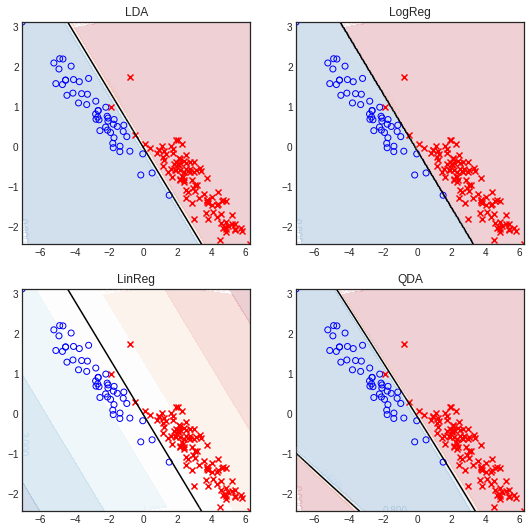

In [ ]:
X_train, y_train = data["train_A"][:, 0:2], data["train_A"][:, -1]
#X_test, y_test = data["test_A"][:, 0:2], data["test_A"][:, -1]


# Note that by setting some of the entries to None you can implement and test each
# of the methods one by one.

# You can erase the following TWO lines once you are comfortable with the codebase.

dummy_class_list = [LDA(X_train, y_train) , LogReg(X_train,y_train), LinReg(X_train,y_train),QDA(X_train,y_train)]
plot_results(X_train, y_train, dummy_class_list)


#dummy_class_list = [LDA(X_test, y_test) , LogReg(X_test,y_test), LinReg(X_test,y_test), QDA(X_test,y_test)]
#plot_results(X_test, y_test, dummy_class_list)

# Your classifiers list should always look like this. Run this when you
# have implemented and tested the methods above.

# classifiers = [model(X_train, y_train) for model in [LDA, LogReg, LinReg, QDA]]
# plot_results(X_train, y_train, classifiers)

In [ ]:
X_train, y_train = data["train_A"][:, 0:2], data["train_A"][:, -1]
model = LinReg(X_train, y_train)
y_train=np.reshape(y_train,(150,1))
X_train_0 = np.reshape(data["train_A"][:, 0],(len(X_train),1))
X_train_1 = np.reshape(data["train_A"][:, 1],(len(X_train),1))
X_test, y_test = data["test_A"][:, 0:2], data["test_A"][:, -1]
y_test=np.reshape(y_test,(len(y_test),1))
X_test_0 = np.reshape(data["test_A"][:, 0],(len(X_test),1))
X_test_1 = np.reshape(data["test_A"][:, 1],(len(X_test),1))
ev_train = pointwise_eval(model, X_train_0, X_train_1)
ev_test = pointwise_eval(model, X_test_0, X_test_1)

predicted_1 = 0+(ev_train>=.5)
print( np.mean(predicted_1 == y_train))

predicted_1_test = 0+(ev_test>=.5)
print(np.mean(predicted_1_test == y_test))

0.9866666666666667
0.9793333333333333


#### Comparison


Method | Train Acc. | Test Acc.
--- | --- | ---
*LDA* | 98.6 % | 98 %
*LogReg* | 100 % | 96.6 %
*LinReg* | 98.66 % | 97.94 %
*QDA* | 99.3 % | 98.1 %


**Question:** Is the misclassiffication error larger, smaller, or similar on the training and test data? Why?

**Answer:** For all classifiers, the misclassification error is larger on the test set. Because the model is trained on the train set and so its parameters are tuned to fit it best.

We also note that one important factor in the closeness of test and train error in the sampling method.



**Question:** Which methods yield very similar/dissimilar results? Which method yield the best results? Provide an interpretation.

**Answer:** Best result is by LDA. Because, dataset A is a mixture of Gaussians with the same covariance, which fits very well to LDA. QDA is a generalization of LDA to a more complex model with more covariance parameters. Therefore, it is expected that it giives similar test error. Also, we observe it has smaller train error which is due to its bigger capacity(expressiveness) and our results nicely show how it overfits on a model which does not require such a complex model to describe it.
LDA and QDA very similar on test set.
And Linreg and LDA give very similar results on the result.

### Dataset B

#### Parameter estimation and plots

6


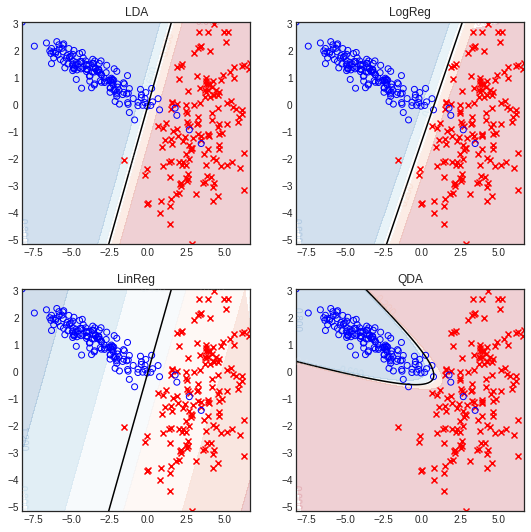

In [ ]:
X_train, y_train = data["train_B"][:, 0:2], data["train_B"][:, -1]
X_test, y_test = data["test_B"][:, 0:2], data["test_B"][:, -1]

dummy_class_list = [LDA(X_train, y_train), LogReg(X_train, y_train), LinReg(X_train, y_train), QDA(X_train, y_train)]
plot_results(X_train, y_train, dummy_class_list)


#dummy_class_list = [LDA(X_test, y_test) , LogReg(X_test,y_test), LinReg(X_test,y_test),QDA(X_test,y_test)]
#plot_results(X_test, y_test, dummy_class_list)

# Your classifiers list should always look like this. Run this when you
# have implemented and tested the methods above.

#classifiers = [model(X_train, y_train) for model in [LDA, LogReg, LinReg, QDA]]
#plot_results(X_train, y_train, classifiers)

In [ ]:
X_train, y_train = data["train_B"][:, 0:2], data["train_B"][:, -1]
model = QDA(X_train, y_train)
y_train=np.reshape(y_train,(len(y_train),1))
X_train_0 = np.reshape(data["train_B"][:, 0],(len(X_train),1))
X_train_1 = np.reshape(data["train_B"][:, 1],(len(X_train),1))
X_test, y_test = data["test_B"][:, 0:2], data["test_B"][:, -1]
y_test=np.reshape(y_test,(len(y_test),1))
X_test_0 = np.reshape(data["test_B"][:, 0],(len(X_test),1))
X_test_1 = np.reshape(data["test_B"][:, 1],(len(X_test),1))
ev_train = pointwise_eval(model, X_train_0, X_train_1)
ev_test = pointwise_eval(model, X_test_0, X_test_1)

predicted_1 = 0+(ev_train>=.5)
print( np.mean(predicted_1 == y_train))

predicted_1_test = 0+(ev_test>=.5)
print(np.mean(predicted_1_test == y_test))

0.9766666666666667
0.9765


#### Comparison


Method | Train Acc. | Test Acc.
--- | --- | ---
*LDA* | 97 % | 95.85 %
*LogReg* | 98 % | 95.7 %
*LinReg* | 97 % | 95.85 %
*QDA* | 97.66 % | 97.65 %


**Question:** Is the misclassiffication error larger, smaller, or similar on the training and test data? Why?

**Answer:**Except for QDA, the misclassification error is larger on the test set than on the train set. Because the model is trained on the train set and so its parameters are tuned to fit it best.

We also note that one important factor in the closeness of test and train error in the sampling method.




**Question:** Which methods yield very similar/dissimilar results? Which method yield the best results? Provide an interpretation.

**Answer:** Thw result of QDA is differenet from all other models and pretty better than them. Since the data generation process B exactly fits the model learned by QDA(because QDA considers the two class conditionals to  be two Gaussians with different means as well as covariances), it is expected that QDA fit best the data.

Interestingly, LDA and LinReg give exactly the same results on both train and test set.

### Dataset C

#### Parameter estimation and plots

5


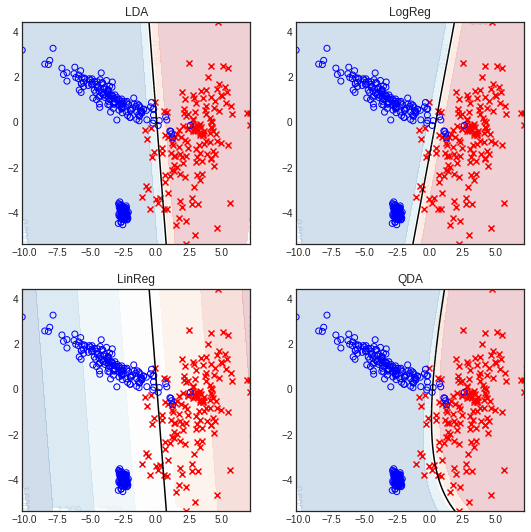

In [ ]:
X_train, y_train = data["train_C"][:, 0:2], data["train_C"][:, -1]
X_test, y_test = data["test_C"][:, 0:2], data["test_C"][:, -1]

dummy_class_list = [LDA(X_train, y_train), LogReg(X_train, y_train),LinReg(X_train, y_train), QDA(X_train, y_train)]
plot_results(X_train, y_train, dummy_class_list)


#dummy_class_list = [LDA(X_test, y_test), LogReg(X_test, y_test),LinReg(X_test, y_test),  LDA(X_test, y_test)]
#plot_results(X_test, y_test, dummy_class_list)

# Your classifiers list should always look like this. Run this when you
# have implemented and tested the methods above.

#classifiers = [model(X_train, y_train) for model in [LDA, LogReg, LinReg, QDA]]
#plot_results(X_train, y_train, classifiers)

In [ ]:
X_train, y_train = data["train_C"][:, 0:2], data["train_C"][:, -1]
model = QDA(X_train, y_train)
y_train=np.reshape(y_train,(len(y_train),1))
X_train_0 = np.reshape(data["train_C"][:, 0],(len(X_train),1))
X_train_1 = np.reshape(data["train_C"][:, 1],(len(X_train),1))
X_test, y_test = data["test_C"][:, 0:2], data["test_C"][:, -1]
y_test=np.reshape(y_test,(len(y_test),1))
X_test_0 = np.reshape(data["test_C"][:, 0],(len(X_test),1))
X_test_1 = np.reshape(data["test_C"][:, 1],(len(X_test),1))
ev_train = pointwise_eval(model, X_train_0, X_train_1)
ev_test = pointwise_eval(model, X_test_0, X_test_1)

predicted_1 = 0+(ev_train>=.5)
print( np.mean(predicted_1 == y_train))

predicted_1_test = 0+(ev_test>=.5)
print(np.mean(predicted_1_test == y_test))

0.9475
0.9596666666666667


#### Comparison


Method | Train Acc. | Test Acc.
--- | --- | ---
*LDA* | 94.5 % | 95.76 %
*LogReg* | 96 % | 97.73 %
*LinReg* | 94.5 % | 95.76 %
*QDA* | 94.75 % | 95.96 %


**Question:** Is the misclassiffication error larger, smaller, or similar on the training and test data? Why?

**Answer:** This time, for all classifiers, the misclassification error is larger on the train set. Interesting!

As said before one important factor regarding this issue can be the sampling method.
 For instance, we can think of one possible scenario:

The train set has many hard cases to learn, for example data points extremely close to eachother, which makes it difficult to train a clear boundary. 

Imagine that OTOH, the test set has mostly easy cases to predict, for example points quite far from the trained decision boundary.


**Question:** Which methods yield very similar/dissimilar results? Which method yield the best results? Provide an interpretation.

**Answer:** LogReg provides the best test accuracy and its result is pretty different than other models on both train and test sets.
Also, as before LinReg and LDA give  very similar results.

Linear Discriminent analysis and linear regression are both special cases of canonical correlation analysis(CCA). This can be considered as a justification for their similar results on all three datasets.

**End of File**

**The rest is not included in my solution to the homework.**

In [ ]:
def LogReg(X, y): #First order analysis.
    """
    Estimates the parameters of a Logistic Regression model
        
        Inputs:
            X: [nx2] matrix of inputs
            Y: [n] vector of labels
        
        Returns:
            LogReg_classifier: function taking two scalar inputs implementing the
                               estimated p(y=1|x)
    """
    # TODO: parameter estimation goes here
    bias = np.ones((len(y),1))
    X = np.concatenate((X,bias),1)
    w = np.random.randn(3,1) #initialization of parameters
    for i in range(10000):
        span = np.dot(X,w)
        sigmoid = (np.exp(-span)+1)**(-1)
        gradw = np.reshape( np.sum(X*(np.reshape(y,(len(y),1))-sigmoid),0) , (3,1))    
       # gradw =  np.sum(X*(y-sigmoid),axis=0)
        w+= -1e-4*gradw 
        if np.absolute(gradw)<1e-3:
          break 
    
    def LogReg_classifier(x0, x1):
         # TODO: use the variables estimated above to define p(y=1|(x0, x1))
        span = np.dot(X,w)
        sigmoid = (np.exp(-span)+1)**(-1)

        return sigmoid
    
    return LogReg_classifier
